In [2]:
!wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/patches_256.zip
!unzip /content/patches_256.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/patches_256/C1_36x70.png  
  inflating: /content/patches_256/C1_36x72.png  
  inflating: /content/patches_256/C1_36x74.png  
  inflating: /content/patches_256/C1_36x76.png  
  inflating: /content/patches_256/C1_36x78.png  
  inflating: /content/patches_256/C1_36x80.png  
  inflating: /content/patches_256/C1_36x82.png  
  inflating: /content/patches_256/C1_36x84.png  
  inflating: /content/patches_256/C1_36x86.png  
  inflating: /content/patches_256/C1_36x88.png  
  inflating: /content/patches_256/C1_36x90.png  
  inflating: /content/patches_256/C1_36x92.png  
  inflating: /content/patches_256/C1_36x94.png  
  inflating: /content/patches_256/C1_36x96.png  
  inflating: /content/patches_256/C1_36x98.png  
  inflating: /content/patches_256/C1_37x101.png  
  inflating: /content/patches_256/C1_37x103.png  
  inflating: /content/patches_256/C1_37x105.png  
  inflating: /content/patches_256/C1_37x107.png  
  inflating: /

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2hed
import seaborn as sns


# Download and load expression data into a dataframe

In [4]:
import pandas as pd
pro_df = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')


pro_df['specimen_id']=pro_df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
pro_df['image_id']=pro_df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+pro_df.id #create image id field
pro_df.set_index('image_id', inplace=True, drop=False)
pro_df.sort_index(inplace=True)
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']
print(pro_df)


          Unnamed: 0                VisSpot  Location_Center_Y  \
image_id                                                         
A1_0x40          412  AAGTAAGCTTCCAAAC-1-A1         764.003658   
A1_0x42         7325  GTTTGAGCGGTTATGT-1-A1         799.511111   
A1_0x44         8102  TCACTCAGCGCATTAG-1-A1         832.902467   
A1_0x46         7085  GTGCGCTTACAAATGA-1-A1         858.343544   
A1_0x48         3748  CGAAGACTGCCCGGGA-1-A1         892.179831   
...              ...                    ...                ...   
D1_9x63         3609  CCTCCCGACAATCCCT-1-D1         123.760525   
D1_9x65          172  AACACGACTGTACTGA-1-D1          29.281573   
D1_9x67         2686  CACCGCCGACCAGCGA-1-D1         938.403662   
D1_9x69         2813  CAGAGTGATTTAACGT-1-D1         844.093656   
D1_9x71         6877  GTCAGTTGTGCTCGTT-1-D1         740.107483   

          Location_Center_X      SMAa     CD11b      CD44      CD31      CDK4  \
image_id                                                    

# Showing an example image

The code below will load an example image. It also shows how you can get the HED channels.

skimage version 0.19.3


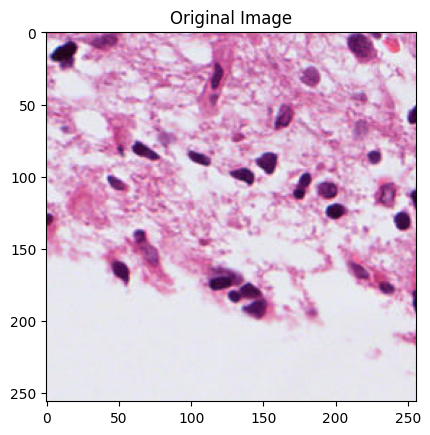

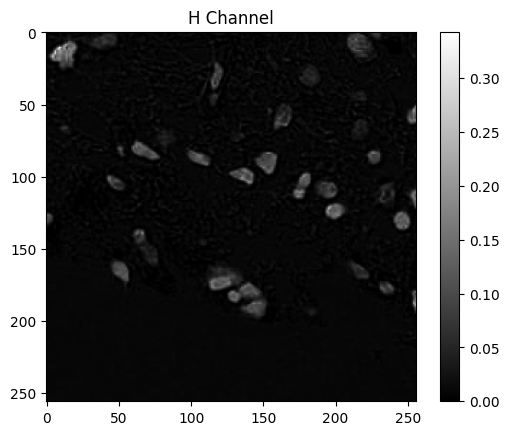

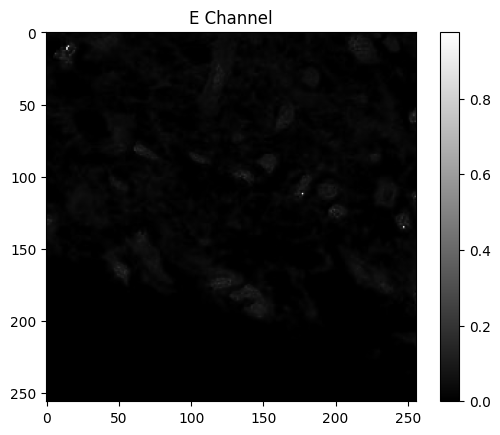

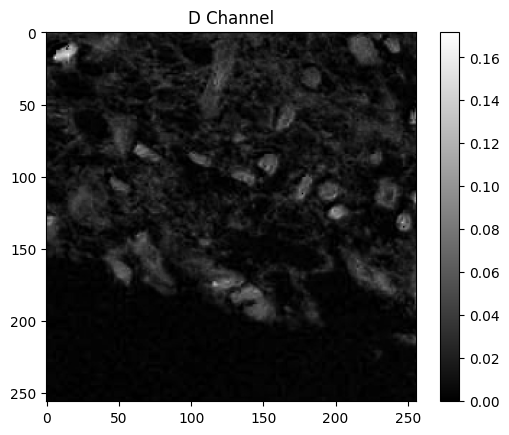

In [5]:
image_folder = '/content/patches_256/'
from skimage.color import rgb2hed
import skimage
from skimage.io import imread
from skimage.color import rgba2rgb
import matplotlib.pyplot as plt

# Replace 'path_to_image' with the path to the image you want to display
image_path = image_folder+'A1_0x40.png'
print('skimage version',skimage.__version__)
import matplotlib.pyplot as plt
I = rgba2rgb(imread(image_path)) #read sample RGB image
I_hed =  rgb2hed(I) #convert to HED
plt.imshow(I);plt.title('Original Image');plt.show()
I_h = I_hed[:,:,0]; plt.figure(); plt.imshow(I_h,cmap='gray');plt.colorbar();plt.title('H Channel');plt.show()
I_e = I_hed[:,:,1]; plt.figure();  plt.imshow(I_e,cmap='gray');plt.colorbar();plt.title('E Channel');plt.show()
I_d = I_hed[:,:,2]; plt.figure();  plt.imshow(I_d,cmap='gray');plt.colorbar();plt.title('D Channel');plt.show()


# Question No. 1: (Data Analysis)
### i. Counting Examples: Determine the number of "examples" or spots present in each specimen.

In [6]:
train_df = pro_df[pro_df['specimen_id'].isin(['A1', 'B1', 'D1'])]#splitting the dataset into train
test_df = pro_df[pro_df['specimen_id'] == 'C1']#splitting the dataset into test

In [7]:
count_train_ex = train_df['specimen_id'].value_counts()
count_test_ex = test_df['specimen_id'].value_counts()
print("The number of examples in training set are:" )
print(count_train_ex)
print("\nThe number of examples in testing set are:")
print(count_test_ex)


The number of examples in training set are:
A1    2894
D1    1753
B1    1145
Name: specimen_id, dtype: int64

The number of examples in testing set are:
C1    4129
Name: specimen_id, dtype: int64


### ii. Protein Expression Histograms: For each specimen, generate histograms to visualize the expression values of 'NESTIN', 'cMYC', and 'MET' and discuss your observations.

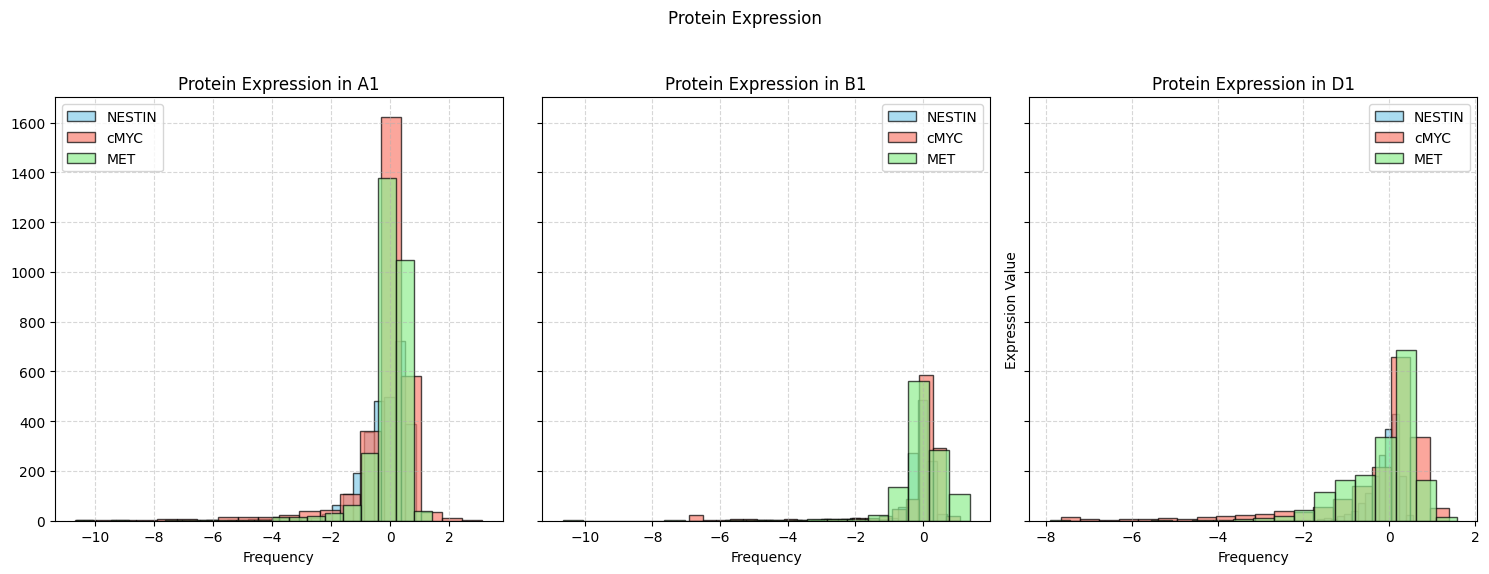

In [8]:
import matplotlib.pyplot as plt

# Protein Expression Histograms for 'NESTIN', 'cMYC', and 'MET' in each specimen
proteins_his = ['NESTIN', 'cMYC', 'MET']

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)  # 3 horizontal subplots
fig.suptitle('Protein Expression')

colors = ['skyblue', 'salmon', 'lightgreen']  # colors for each protein
markers = ['o', 's', '^']  # Different marker styles for each protein

for j, specimen_id in enumerate(['A1', 'B1', 'D1']):
    ax = axes[j]
    #dataset filtering for the current specimen and plotting
    for i, protein in enumerate(proteins_his):
        specimen_data = train_df[train_df['specimen_id'] == specimen_id]
        ax.hist(specimen_data[protein].dropna(), bins=20, color=colors[i], alpha=0.7, label=protein, edgecolor='black')
        ax.grid(True, linestyle='--', alpha=0.5)  # for grid lines
        ax.set_title(f'Protein Expression in {specimen_id}')
        ax.set_xlabel('Frequency')
        ax.legend()

plt.ylabel('Expression Value')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Discussion:

Specimen A1:


*   NESTIN:Expression Values are relatively low from -2 to 0 showing a narrow distribution.
*   cMYC: This shows a similar pattern but with a slight positive value(right) shift compared to NESTIN.This indicates a slighty higher expression level.
*  MET: Compared to the other two proteins, it seems that its expression varies more over the specimen due to its wider distribution and spike around -1.

Specimen B1:


*   NESTIN:The expression is low but unlike in A1, it exhibits a graph which rises close to -6 and -2(bimodal distribution).
*   cMYC:Again this appears to have a very low expression level with only few occurances a bit above the baseline.
*   Similar to A1, it has a large rise at -1, indicating that it is uniformly expressed in various specimens.

Specimen D1:

*   NESTIN:The expression levels exhibit variation, with a minor increase at about -2.
*   cMYC: Again shows a low expression level, similar to B1
*   MET:It has the most broad distribution of the three specimens, with a noticeable peak at -1 and  along with a range of values from -4 to 0.

Overall:


*   Each specimen exhibits distinct patterns from NESTIN, indicating that the this protein expression  may be more environment-dependent.
*   Across all specimens, MET tends to have a wider range of expression values, indicating that its expression is more variable within these specimens.
*   Across all the three specimens, cMYC exhibits the lowest expression levels, with the majority of its values falling under the baseline.

























### iii. Image Pre-processing: Convert a selection of images from RGB to HED color space,focusing on the Hematoxylin channel (H) to highlight cellular nuclei. Provide visual examples and follow the hints in the provided notebook.

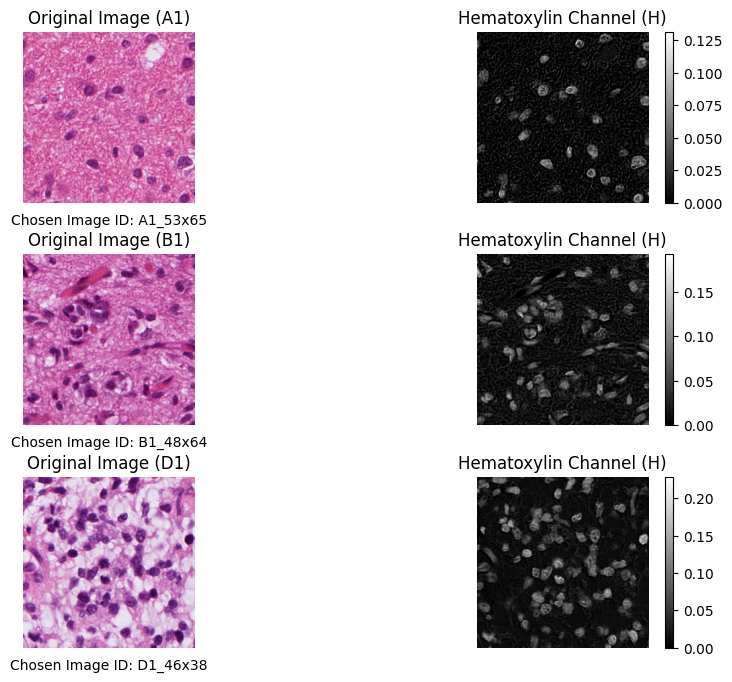

In [9]:
import random

image_folder = '/content/patches_256/'

# Lists to store randomly selected image IDs for each set
sel_A1 = random.choice(train_df[train_df['specimen_id'] == 'A1'].index.tolist())
sel_B1 = random.choice(train_df[train_df['specimen_id'] == 'B1'].index.tolist())
sel_D1 = random.choice(train_df[train_df['specimen_id'] == 'D1'].index.tolist())


plt.figure(figsize=(10, 8))# subplots

# Loop through the selected images for each set
for i, (selected_id, specimen_id) in enumerate(zip([sel_A1, sel_B1, sel_D1], ['A1', 'B1', 'D1']), start=1):
    image_path = image_folder + selected_id + '.png'#image path
    I = imread(image_path)# sample image
    #RGBA to RGB
    if I.shape[2] == 4:
        I_rgb = rgba2rgb(I)
    else:
        I_rgb = I

    # HED color space
    I_hed = rgb2hed(I_rgb)

    # Display the original RGB image
    plt.subplot(3, 2, 2*i-1)
    plt.imshow(I_rgb)
    plt.title(f'Original Image ({specimen_id})')
    plt.axis('off')  # Turn off axis labels
    plt.text(0.5, -0.1, f'Chosen Image ID: {selected_id}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    # Display the Hematoxylin channel (H)
    I_h = I_hed[:, :, 0]
    plt.subplot(3, 2, 2*i)
    plt.imshow(I_h, cmap='gray')
    plt.colorbar()
    plt.title('Hematoxylin Channel (H)')
    plt.axis('off')  # Turn off axis labels

# spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()


### iv) H-channel Analysis: Calculate the average intensity of the H-channel for each image.Create a scatter plot comparing these averages against the expression levels of NESTIN for each image. Assess the correlation between H-channel intensity and NESTIN expression.Discuss the potential of H-channel average as a predictive feature for NESTIN expression.

<ipython-input-10-673c8b1e1cd2>:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(h_intensity, nestin_ex, c=colors, cmap='viridis', alpha=0.7)


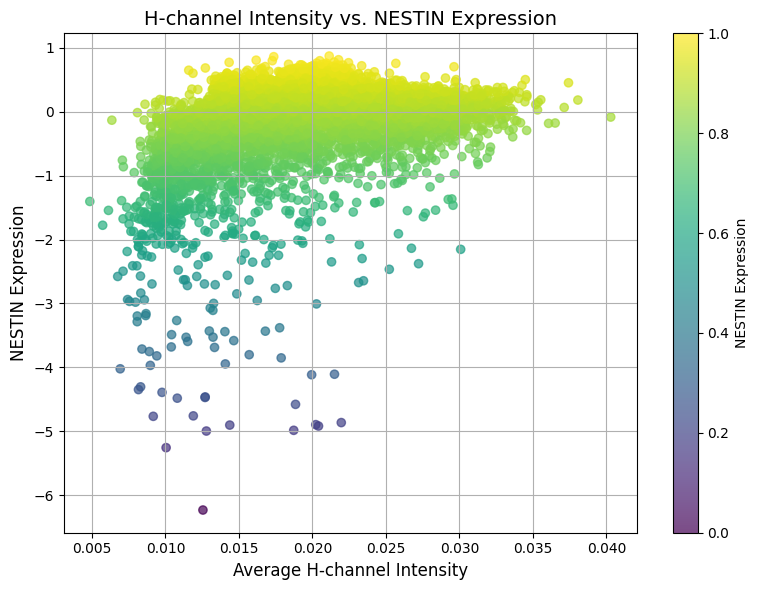

Correlation between H-channel intensity and NESTIN expression is 0.37961630986626616


In [10]:
from matplotlib.colors import Normalize
from matplotlib import cm  # cm module for color maps

#Calculating the average intensity of the H-channel for each image
h_intensity = []
for image_id in train_df.index:
    image_path = image_folder + image_id + '.png'
    image = imread(image_path)

    # RGBA to RGB
    if image.shape[2] == 4:
        image_rgb = rgba2rgb(image)
    else:
        image_rgb = image

    # HED color space
    image_hed = rgb2hed(image_rgb)

    # Extracting the Hematoxylin channel (H)
    h_channel = image_hed[:, :, 0]

    # Calculating the average intensity of the above H-channel
    average_intensity = np.mean(h_channel)

    # Appending to the list of H-channel intensities
    h_intensity.append(average_intensity)

# Retrieving the NESTIN expression levels  for each image
nestin_ex = train_df['NESTIN']

# Creating  scatter plot comparing H-channel intensity and NESTIN expression
norm = Normalize(vmin=min(nestin_ex), vmax=max(nestin_ex))
colors = cm.viridis(norm(nestin_ex))# Creating  color map based on NESTIN expression levels

# Creating the scatter plot with color mapping
plt.figure(figsize=(8, 6))
plt.scatter(h_intensity, nestin_ex, c=colors, cmap='viridis', alpha=0.7)
plt.title('H-channel Intensity vs. NESTIN Expression', fontsize=14)
plt.xlabel('Average H-channel Intensity', fontsize=12)
plt.ylabel('NESTIN Expression', fontsize=12)
plt.colorbar(label='NESTIN Expression')
plt.grid(True)
plt.tight_layout()
plt.show()

#Assessing the correlation between H-channel intensity and NESTIN expression
h_correlation = np.corrcoef(h_intensity, nestin_ex)[0, 1]
print(f'Correlation between H-channel intensity and NESTIN expression is {h_correlation}')


Positive Trend:
*   The expression of NESTIN is positively correlated with the intensity of the H-channel which is 0.3796 respectively.  As the H-channel intensity increases, NESTIN expression tends to increase as well.
*   This positive trend suggests that H-channel intensity could be a meaningful variable to include when trying to predict NESTIN expression.  The key to developing successful models involves identifying and choosing such useful variables.

Correlation:
*   At greater expression levels, the correlation seems to decrease, indicating to the possibility of a non-linear relationship or the involvement of additional factors.
*   The possible non-linear relationship between H-channel intensity and NESTIN expression implies that models capable of handling complex patterns might be necessary for accurate predictions.

Outliers:
*   As mentioned before,some data points with high H-channel intensity do not correspond to similarly high levels of NESTIN expression, indicating that the correlation is not perfect and other factors might affect NESTIN expression.
*   The presence of outliers stresses the importance of using strong analysis methods to reduce their influence and maintain the generalizability and dependability of the model.

Potential for Predictive Feature:
* The average H-channel intensity has potential to predict NESTIN expression, but its accuracy would be enhanced by combining it with additional characteristics. Its predictive validity will have to be confirmed by a statistical correlation analysis.
*   H-channel intensity's potential as a predictor stimulates the development of multivariable models that can take use of this capability, maybe when combined with other factors for improved precision and insights.



### v) Performance Metrics for Prediction: Discuss suitable performance metrics for predicting protein expression from images. Identify the most appropriate metric for this specific problem and justify your choice.



List of Suitable performance metrics
*   MAE calculates  the average absolute difference  between the actual and predicted values gives an easy way to determine the degree of error.

*   MSE is the measure of average squared error between the expected and actual values  , which restricts major errors more severely than MAE.

*   RMSE: Square root of MSE, providing an interpretable measure of error magnitude in the same units as the target variable.
*   R-squared: Measures how much of the target variable's variation the model can account for, showing how well the model fits the data.
*   MAPE provides a helpful relative measure of error for understanding performance over a broad range of expression values. It measures the average percentage difference between predicted and actual values.

###Most appropriate metric for this specific problem:
###MAE-Mean Absolute Error:
It is suitable as it gives an independent measurement of the average size of errors between the values of protein expression that are predicted and those that are observed.

It provides simple interpretation and assessment of prediction accuracy in the context of this problem which is protein expression prediction from images, where accurate quantitative measurements are crucial. Furthermore, MAE is a reliable metric for assessing model performance since it is less susceptible to outliers, which might happen as a result of noise or differences in image quality.

Suppose there's an outlier where the predicted value is 10 units higher than the actual value. In MAE, this error contributes only 10 units to the overall average, whereas in MSE and RMSE, the squared error would magnify its impact, potentially skewing the evaluation.
Error Squared Root Mean (RMSE):

### Rationale: Root Mean Square Error (RMSE):

It is a suitable metric here since it highlights greater differences between the expected and observed protein expression levels, in addition to assessing the average error magnitude. By targeting bigger errors progressively, RMSE offers a more thorough assessment in the context of protein expression prediction from pictures, where precise measurement of errors is essential.
For example, if the model predicts an expression value of 7 for a patch where the actual value is 2, the squared error would be (7-2)^2 = 25, which contributes significantly to RMSE.

In addition, RMSE allows for the easy interpretation of prediction accuracy in relation to protein expression levels by expressing error magnitude in the same units as the target variable.
###Spearman Rank Correlation Coefficient:
When it comes to protein expression analysis, Spearman correlation provides important information about how well the model captures the underlying connections, as the relative ordering of protein expression levels across several image patches is frequently more important than the absolute values.

It evaluates how well the predicted rankings match the actual rankings of protein expression across these patches. In case, if the actual protein expression values are [2, 4, 6, 8] and the model predicts [1, 3, 7, 9], although the exact values differ, Spearman correlation would indicate a strong positive correlation as the rankings are preserved (both lists are in ascending order).






## Question No. 2: (Feature Extraction and Classical Regression)
### i)1. Calculate the average and variance for each of the 'H' (from HED), red, green, and blue channels.


In [11]:
import numpy as np

# function to calculate average and variance for each channel
def cal_features(image_ids, image_folder):
    features_img = []

    for image_id in image_ids:
        if 'C1' not in image_id:  # for Excluding images from specimen C1
            # Read the image
            image_path = image_folder + image_id + '.png'
            image = imread(image_path)

            # RGBA to RGB if needed
            if image.shape[2] == 4:
                image_rgb = rgba2rgb(image)
            else:
                image_rgb = image

            # Calculating average and variance for each channel
            avg_h = np.mean(rgb2hed(image_rgb)[:, :, 0])
            var_h = np.var(rgb2hed(image_rgb)[:, :, 0])

            avg_red = np.mean(image_rgb[:, :, 0])
            var_red = np.var(image_rgb[:, :, 0])

            avg_green = np.mean(image_rgb[:, :, 1])
            var_green = np.var(image_rgb[:, :, 1])

            avg_blue = np.mean(image_rgb[:, :, 2])
            var_blue = np.var(image_rgb[:, :, 2])

            # Appending features for the current image
            features_img.append({
                'Image_ID': image_id,
                'Avg_H': avg_h,
                'Var_H': var_h,
                'Avg_Red': avg_red,
                'Var_Red': var_red,
                'Avg_Green': avg_green,
                'Var_Green': var_green,
                'Avg_Blue': avg_blue,
                'Var_Blue': var_blue
            })

    return features_img

# Calculating features for images from specimens A1, B1, and D1
train_image_ids = train_df.index
image_features = cal_features(train_image_ids, image_folder)

# Displaying features
import pandas as pd
image_features_df = pd.DataFrame(image_features)
print(image_features_df)


     Image_ID     Avg_H     Var_H     Avg_Red      Var_Red   Avg_Green  \
0     A1_0x40  0.013534  0.000378    0.848883     0.015943    0.711311   
1     A1_0x42  0.015797  0.000390    0.792615     0.019044    0.526604   
2     A1_0x44  0.015550  0.000353    0.782706     0.017117    0.479398   
3     A1_0x46  0.017684  0.000379    0.756006     0.017842    0.424319   
4     A1_0x48  0.017878  0.000430    0.750721     0.018957    0.403713   
...       ...       ...       ...         ...          ...         ...   
5787  D1_9x63  0.022720  0.000841  203.982468  2071.958540  174.091537   
5788  D1_9x65  0.029724  0.001032  187.562576  2361.134665  137.292404   
5789  D1_9x67  0.031511  0.001079  184.515610  2402.849244  132.275436   
5790  D1_9x69  0.029586  0.001038  187.973434  2340.175091  137.014587   
5791  D1_9x71  0.028061  0.000861  189.872513  2080.200284  139.777649   

        Var_Green    Avg_Blue     Var_Blue  
0        0.047447    0.823697     0.020808  
1        0.039862    

<ipython-input-12-2065f96a8284>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Feature', y='Value', data=melted_features_df, palette=palette, jitter=True, size=6)
<ipython-input-12-2065f96a8284>:9: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.stripplot(x='Feature', y='Value', data=melted_features_df, palette=palette, jitter=True, size=6)


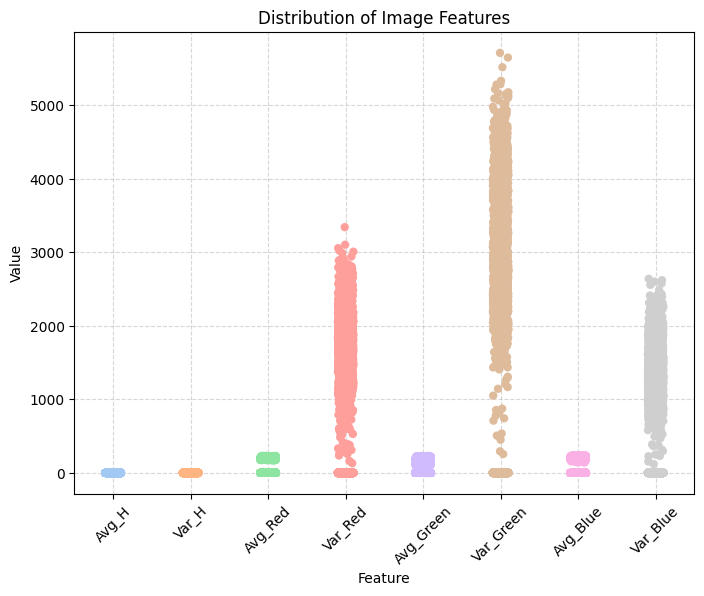

In [12]:

# Assuming image_features_df is your DataFrame with image features
melted_features_df = pd.melt(image_features_df, id_vars=['Image_ID'], var_name='Feature', value_name='Value')

# Set a color palette for the stripplot
palette = sns.color_palette('pastel')

# Plot stripplot with visually appealing color
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.stripplot(x='Feature', y='Value', data=melted_features_df, palette=palette, jitter=True, size=6)
plt.title('Distribution of Image Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines for better visualization
plt.show()


Observations:

The average hue (Avg_H) and average blue (Avg_Blue) have relatively low and tightly grouped values, suggesting a limited range of intensity across these channels.

The variance for red (Var_Red) and green (Var_Green) channels show a wide range and more spread out values, indicating greater variability in the intensities across different patches of the images.

Outliers are particularly noticeable in the variance features, which might indicate regions of high contrast or anomalies in the images.

### 2)i.2 Additionally, consider other potentially useful features for this task and justify their inclusion. For example: PCA (Principal Component Analysis):

In [13]:
import pandas as pd
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray, gray2rgb
from skimage.transform import rescale
import os
import numpy as np
from sklearn.decomposition import PCA

# function to extract features using PCA
def extract_pca_features(image_ids, image_folder, explained_variance_threshold=0.95):
    pca_features = []

    for filename in os.listdir(image_folder):
        if filename.endswith('.png') and any(identifier in filename for identifier in image_ids):
            image_path = os.path.join(image_folder, filename)
            image = imread(image_path)

            if image.shape[2] == 4:
                image = rgba2rgb(image)

            # Converting to grayscale
            image_gray = rgb2gray(image)

            # Converting grayscale image back to RGB
            image_rgb = gray2rgb(image_gray)

            # Resizing image to a smaller resolution, e.g., (50, 50)
            image_rescaled = rescale(image_rgb, scale=0.2, anti_aliasing=True)

            image_flattened = image_rescaled.flatten()  # Flatten the resized image
            pca_features.append({
                'image_id': filename.split('.')[0],
                'Image': image_flattened
            })

    # Converting list of dictionaries to DataFrame
    df = pd.DataFrame(pca_features)

    # Extracting features for PCA
    X = np.array(df['Image'].tolist())

    # Initializing PCA, specifying the desired amount of variance to be preserved
    pca = PCA(n_components=explained_variance_threshold, random_state=42, svd_solver='full')

    # Applying PCA transformation
    X_pca = pca.fit_transform(X)

    # Creating a DataFrame to combine PCA features with image IDs
    pca_features_df = pd.DataFrame(X_pca)

    # Moveing "Image_ID" column to the first position
    pca_features_df = pd.concat([df['image_id'], pca_features_df], axis=1)

    # Renameing the columns
    pca_features_df.columns = ['image_id'] + [f'PC{i}' for i in range(pca_features_df.shape[1] - 1)]

    # Printing the explained variance ratio of each principal component to understand the distribution
    print("Variance ratio:")
    print(pca.explained_variance_ratio_)

    return pca_features_df

# Extracting PCA features for images from specimens A1, B1, and D1
pca_features_df = extract_pca_features(['A1', 'B1', 'D1'], '/content/patches_256/')

# Displaying PCA features DataFrame
print(pca_features_df)


Variance ratio:
[2.60639468e-01 3.48470629e-02 2.65418227e-02 1.14647818e-02
 9.32091371e-03 7.80026630e-03 6.24342366e-03 5.58191262e-03
 4.92181994e-03 4.75345142e-03 4.61397366e-03 4.17866490e-03
 3.89876221e-03 3.66501817e-03 3.52355234e-03 3.43681477e-03
 3.27034265e-03 3.22284595e-03 3.17820401e-03 3.00568267e-03
 2.97049328e-03 2.89643078e-03 2.81018971e-03 2.78639282e-03
 2.73963581e-03 2.71657779e-03 2.61447081e-03 2.59875410e-03
 2.56038348e-03 2.54393726e-03 2.50878929e-03 2.47068377e-03
 2.44727673e-03 2.44435968e-03 2.40305814e-03 2.36693600e-03
 2.33758000e-03 2.31893908e-03 2.28969777e-03 2.28150145e-03
 2.27093895e-03 2.25015509e-03 2.22262097e-03 2.19967078e-03
 2.16854891e-03 2.15610762e-03 2.12691526e-03 2.11457120e-03
 2.08602581e-03 2.07815268e-03 2.05296875e-03 2.03826171e-03
 2.03029630e-03 2.02524301e-03 2.01169976e-03 2.00019576e-03
 1.98020670e-03 1.96877530e-03 1.95095182e-03 1.93043070e-03
 1.91861992e-03 1.90837038e-03 1.88190082e-03 1.87637677e-03
 1.86746

### PCA inclusion:
PCA is a useful tool for extracting the most important features from image data and removing redundant or less informative ones, which is critical for the task at present—developing machine learning models to predict protein expression patterns. By concentrating on the most important characteristics, this speeds up the model training process and also increases model accuracy. In addition, hidden patterns associated with protein expression that are not visible in the raw data may be revealed by PCA-transformed features, leading to a more thorough knowledge and precise predictions of protein expression profiles.

### Feature Evaluation:

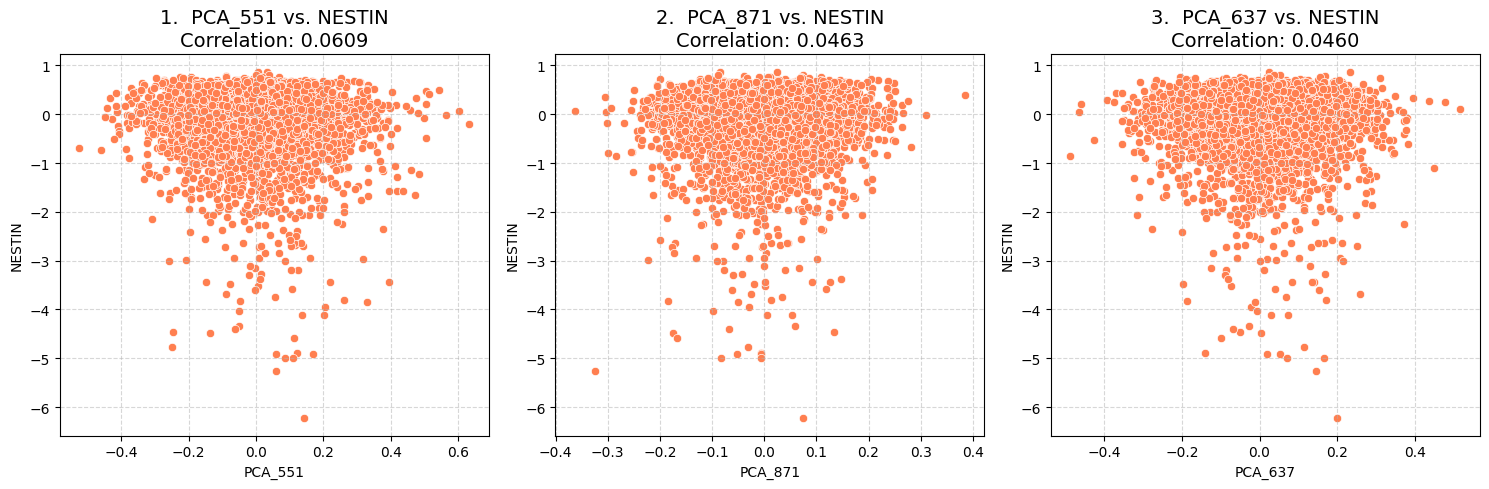

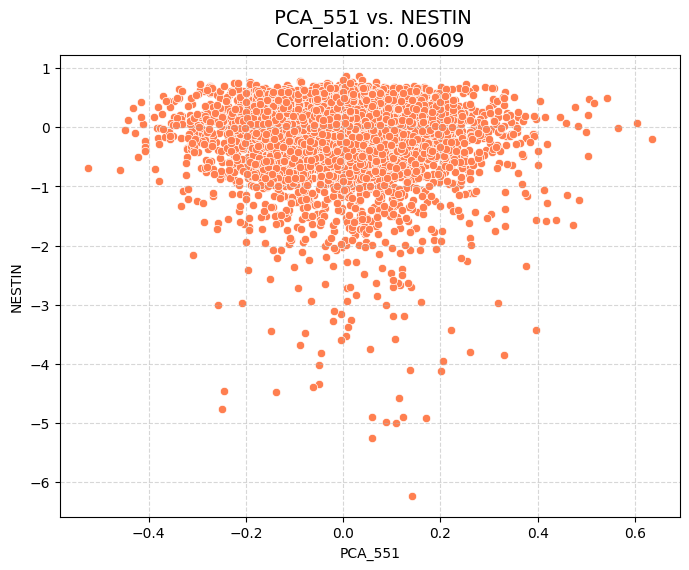

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def vis_pca(X_pca, y, target_variable, pca_feature_prefix='PCA_', scatter_kwargs=None, **plot_kwargs):
    # DataFrame conversion for PCA features
    df_pca = pd.DataFrame(X_pca, columns=[f'{pca_feature_prefix}{i}' for i in range(X_pca.shape[1])])

    # Concatenating PCA features with the target variable into one DataFrame
    df_final = pd.concat([df_pca, y.rename(target_variable)], axis=1)

    # Calculating the correlation of each PCA feature with the target variable
    correlations_pca = df_final.corr()[target_variable].drop(target_variable)

    # Identifying the top three most predictive PCA features
    top_features = correlations_pca.abs().nlargest(3)

    # Generating scatter plots for the top three most predictive PCA features
    plt.figure(figsize=(15, 5))
    for i, (feature, correlation) in enumerate(zip(top_features.index, top_features.values), 1):
        plt.subplot(1, 3, i)
        sns.scatterplot(x=df_final[feature], y=df_final[target_variable], **scatter_kwargs)
        plt.title(f'{i}.  {feature} vs. {target_variable}\nCorrelation: {correlation:.4f}', **plot_kwargs)
        plt.xlabel(feature, **plot_kwargs.get('xlabel', {}))
        plt.ylabel(target_variable, **plot_kwargs.get('ylabel', {}))
        plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines

    plt.tight_layout()

    plt.show()

    # Identifying the most predictive feature among the top three
    most_predictive_feature = top_features.idxmax()

    # Generating a separate scatter plot for the most predictive feature among the top three
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_final[most_predictive_feature], y=df_final[target_variable], **scatter_kwargs)
    plt.title(f' {most_predictive_feature} vs. {target_variable}\nCorrelation: {top_features[most_predictive_feature]:.4f}', **plot_kwargs)
    plt.xlabel(most_predictive_feature, **plot_kwargs.get('xlabel', {}))
    plt.ylabel(target_variable, **plot_kwargs.get('ylabel', {}))
    plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines
    plt.show()



metadata = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')
train_val_specimens = ['A1', 'B1', 'D1']
metadata['specimen_id'] = metadata.VisSpot.apply(lambda x: x.split('-')[2])  # Create specimen id field
metadata = metadata[metadata['specimen_id'].isin(train_val_specimens)]
y = metadata['NESTIN']

# Calling the function with PCA features and target variable, and customize the scatter plot
scatter_kwargs = {'marker': 'o', 'color': 'coral'}
plot_kwargs = {'fontsize': 14}  #  change title font size
vis_pca(pca_features_df.iloc[:, 1:].values, y, 'NESTIN', scatter_kwargs=scatter_kwargs, **plot_kwargs)


The scatter plots show the relationship between the first three high performance principal components obtained via PCA and the protein expression levels of NESTIN.
* In predictive modeling, especially in complex domains like protein expression, features with low individual correlation coefficients may still contribute to model performance when combined with other features. This is because they might capture different aspects of the underlying structure in the data that are not apparent when each feature is considered in isolation.

* The combined effect of multiple weak predictors can be significant if they capture different underlying signals or patterns in the data.
In ensemble methods or models that capture non-linear relationships, such as random forests or neural networks, these features can contribute to splits or decision paths that improve the model's overall predictive power.


* The features derived from PCA are combinations of the original variables, so even if the correlation with NESTIN expression is low, they may still be reducing the dimensionality of the data in a way that preserves important information for prediction.

* Despite the low individual correlations of top
performance components with NESTIN expression levels, their true value comes from their collective contribution to the predictive model.

## ii)Apply the following regression models

 Ordinary Least Squares (OLS) and Support Vector Regression (SVR)


Evaluating OLS Model

OLS Model Results:
RMSE: 0.5912540353445445
Pearson Correlation Coefficient: 0.5512835140138679
Spearman Correlation Coefficient: 0.6338981003566562
R2 Score: 0.20193937942431806


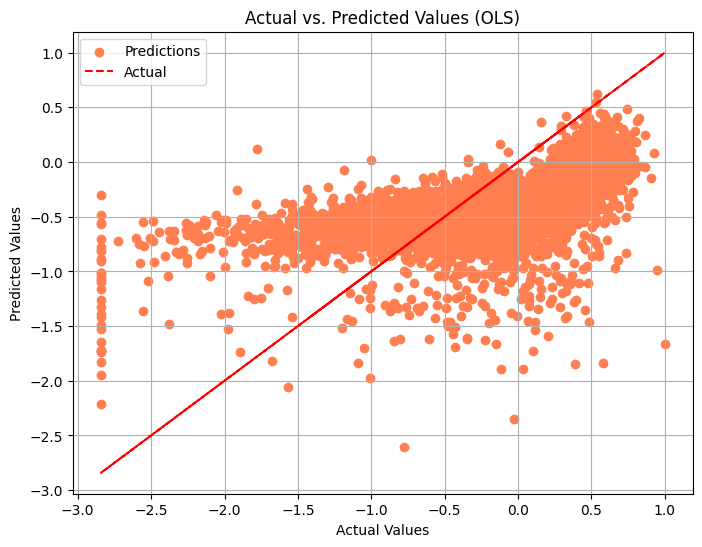


Evaluating SVR Model

SVR Model Results:
RMSE: 0.5930473583182178
Pearson Correlation Coefficient: 0.6051635630320839
Spearman Correlation Coefficient: 0.691197043791403
R2 Score: 0.1970908682781305


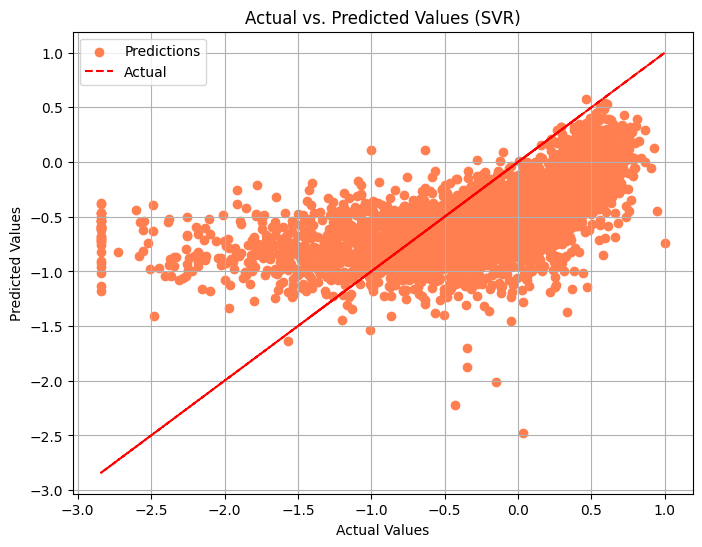

In [17]:
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2hed
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.svm import SVR
import matplotlib.pyplot as plt

model_performance={}  # Dictionary to store model performance metrics

# Function to read and process image
def read_and_process_image(img_path, target_shape=(25, 25)):
    img = imread(img_path)
    if img.shape[-1] == 4:  #  RGBA to RGB if alpha channel exists
        img = rgba2rgb(img)
    img_resized = resize(img, target_shape, anti_aliasing=True)  # Resize image
    img_hed = rgb2hed(img_resized)  #  image to HED color space
    # Concatenate features: H channel from HED, and RGB channels from resized image
    features = np.concatenate([
        img_hed[:, :, 0].flatten(),  # H channel
        img_resized[:, :, 2].flatten(),  # Blue channel
        img_resized[:, :, 1].flatten(),  # Green channel
        img_resized[:, :, 0].flatten()   # Red channel
    ])
    return features

# Function to extract features from images
def extract_features(image_ids, img_dir, target_shape=(25, 25)):
    # Extract features for each image
    features = [read_and_process_image(f"{img_dir}/{img_id}.png", target_shape) for img_id in image_ids]
    return np.array(features)

# Function to preprocess features (PCA and scaling)
def preprocess_features(X_train, X_test, n_components=0.95):
    pca = PCA(n_components=n_components)  # PCA for dimensionality reduction
    X_train_pca = pca.fit_transform(X_train)  # Fit PCA on training data and transform it
    X_test_pca = pca.transform(X_test)  # Transforming test data using trained PCA

    scaler = StandardScaler()  # Standardize features by removing the mean and scaling to unit variance
    X_train_scaled = scaler.fit_transform(X_train_pca)  # Fitting scaler on training data and transform it
    X_test_scaled = scaler.transform(X_test_pca)  # Transforming test data using trained scaler

    return X_train_scaled, X_test_scaled

# Function to train and evaluate models
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    if model_type == 'OLS':
        # Ordinary Least Squares (OLS) Regression
        X_train_const = sm.add_constant(X_train)  # Add constant column to X_train for intercept
        model = sm.OLS(y_train, X_train_const).fit()  # Fit OLS model
        X_test_const = sm.add_constant(X_test)  # Add constant column to X_test for intercept
        predictions = model.predict(X_test_const)  # Make predictions on test data
    elif model_type == 'SVR':
        # Support Vector Regression (SVR)
        model = SVR(C=1.0, epsilon=0.2)  # Define SVR model
        model.fit(X_train, y_train)  # Fit SVR model
        predictions = model.predict(X_test)  # Make predictions on test data
    else:
        raise ValueError("Invalid model type. Choose 'OLS' or 'SVR'.")

    # Calculating evaluation metrics
    mse = mean_squared_error(y_test, predictions)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    pearson_corr, _ = pearsonr(y_test, predictions)  # Pearson Correlation Coefficient
    spearman_corr, _ = spearmanr(y_test, predictions)  # Spearman Correlation Coefficient
    r2 = r2_score(y_test, predictions)  # R-squared score

    # Storing model performance metrics in dictionary
    if model_type == 'OLS':
        model_performance['OLS'] = {
            'RMSE': rmse,
            'Pearson Correlation Coefficient': pearson_corr,
            'Spearman Correlation Coefficient': spearman_corr,
            'R2 Score': r2
        }
    else:
        model_performance['SVR'] = {
            'RMSE': rmse,
            'Pearson Correlation Coefficient': pearson_corr,
            'Spearman Correlation Coefficient': spearman_corr,
            'R2 Score': r2
        }

    # Print and visualize model results
    print(f"\n{model_type} Model Results:")
    print(f"RMSE: {rmse}")
    print(f"Pearson Correlation Coefficient: {pearson_corr}")
    print(f"Spearman Correlation Coefficient: {spearman_corr}")
    print(f"R2 Score: {r2}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, color='coral', label='Predictions')
    plt.plot(y_test, y_test, color='red', linestyle='--', label='Actual')
    plt.title(f'Actual vs. Predicted Values ({model_type})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Directory containing images
img_dir = 'patches_256/'

# Extracting features from images for training and testing sets
X_train = extract_features(train_df['image_id'].values, img_dir)
X_test = extract_features(test_df['image_id'].values, img_dir)

# Preprocessing features (PCA and scaling)
X_train_scaled, X_test_scaled = preprocess_features(X_train, X_test)

# Training and evaluating using OLS model
print("Evaluating OLS Model")
train_and_evaluate(X_train_scaled, train_df['NESTIN'], X_test_scaled, test_df['NESTIN'], model_type='OLS')

# Training and evaluating using SVR model
print("\nEvaluating SVR Model")
train_and_evaluate(X_train_scaled, train_df['NESTIN'], X_test_scaled, test_df['NESTIN'], model_type='SVR')


###OLS Model Results:

RMSE (Root Mean Squared Error): At 0.5913, the OLS model has a relatively low error magnitude on the predicted values, which is good. However, without a benchmark or a baseline model's RMSE for comparison, it's difficult to assess if this is the best possible outcome.

Pearson Correlation Coefficient: The value of 0.5513 indicates a moderate positive linear relationship between the predicted and actual values of protein expression. The model captures some of the variability in the data, but there's still room for improvement.

Spearman Correlation Coefficient: At 0.6339, the model has a reasonably good rank correlation, suggesting it's better at capturing the relative ordering of the data points rather than the precise values.

R² Score: The score of 0.2019 indicates that approximately 20% of the variance in the protein expression levels is explained by the OLS model. This is quite low, meaning there's a lot of unexplained variance.

### SVR Model Results:

RMSE: The RMSE for SVR is slightly higher at 0.5930, indicating a marginally poorer performance in terms of error magnitude compared to the OLS model.

Pearson Correlation Coefficient: An improved correlation of 0.6052 compared to the OLS model indicates a better linear relationship between the predicted and actual values. This suggests that SVR captures more of the linear variability in the data than OLS.

Spearman Correlation Coefficient: At 0.6912, the SVR model shows a strong positive rank correlation, better than the OLS model. This means the SVR model is more effective at modeling the correct order of the data points.

R² Score: The score is slightly lower at 0.1971, suggesting that the SVR model explains slightly less of the variance in the data than the OLS model.

## Question No. 3 (Using Convolutional Neural Networks)
(i)

Epoch 1/5, Loss: 26.372078145571177
Epoch 2/5, Loss: 0.29980248002880844
Epoch 3/5, Loss: 0.2594089125648388
Epoch 4/5, Loss: 0.23903200347285244
Epoch 5/5, Loss: 0.18259281263743316
RMSE: 0.5456, Pearson Correlation: 0.5947, Spearman Correlation: 0.6864, R2 Score: 0.3205


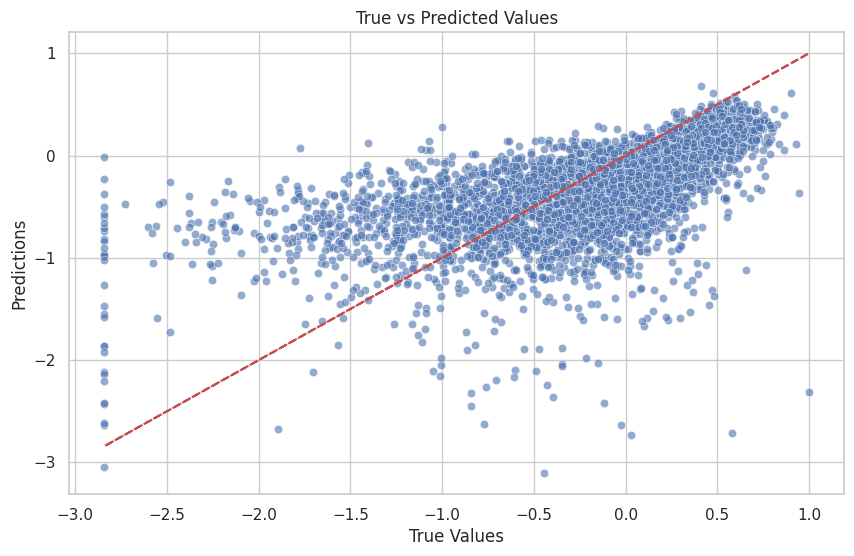

In [19]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

class CustomDataset(Dataset):
    """A custom dataset class for loading and transforming images and targets."""
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['image_id'] + '.png')
        image = Image.open(img_name).convert('RGB')
        target = self.dataframe.iloc[idx]['NESTIN']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target, dtype=torch.float32)

def preprocess_data(url):
    """Preprocesses the dataset by reading, cleaning, and formatting."""
    df = pd.read_csv(url)
    df['image_id'] = df['VisSpot'].apply(lambda x: x.split('-')[2]) + '_' + df['id'].astype(str)
    df['Specimen'] = df['VisSpot'].apply(lambda x: x.split('-')[2])
    df['NESTIN'] = pd.to_numeric(df['NESTIN'], errors='coerce')
    df.dropna(subset=['NESTIN'], inplace=True)
    return df

def split_dataset(df, train_specimens, test_specimens):
    """Splits the dataset into training and testing sets based on specimen IDs."""
    training_data_set = df[df['Specimen'].isin(train_specimens)]
    testing_data_set = df[df['Specimen'].isin(test_specimens)]
    return training_data_set, testing_data_set

def create_dataloaders(train_df, test_df, root_dir, transform, batch_size=32):
    """Creates DataLoader objects for training and testing datasets."""
    train_dataset = CustomDataset(dataframe=train_df, root_dir=root_dir, transform=transform)
    test_dataset = CustomDataset(dataframe=test_df, root_dir=root_dir, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network model."""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 128 * 32 * 32)
        x = self.fc_layers(x)
        return x

def train_model(model, criterion, optimizer, train_loader, epochs=5):
    """Trains the model using the provided DataLoader."""
    model.train()
    train_losses=[]
    for epoch in range(epochs):
        total_loss = 0.00
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
        epoch_loss = total_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}')
    return train_losses

def evaluate_model(model, test_loader):
    """Evaluates the model on the test set and prints performance metrics."""
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for images, targets_batch in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze()

            # Convert outputs to NumPy array if it's not 0-dimensional
            if outputs.dim() > 0:
                predictions.extend(outputs.cpu().numpy())
            else:
                predictions.append(outputs.item())

            # Convert targets_batch to NumPy array if it's not 0-dimensional
            if targets_batch.dim() > 0:
                targets.extend(targets_batch.numpy())
            else:
                targets.append(targets_batch.item())

    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    pearson_corr, _ = pearsonr(targets, predictions)
    spearman_corr, _ = spearmanr(targets, predictions)
    r2 = r2_score(targets, predictions)

    print(f"RMSE: {rmse:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}, R2 Score: {r2:.4f}")
    plot_predictions_vs_targets(targets, predictions)

def plot_predictions_vs_targets(targets, predictions):
    """Plots the scatter plot of true vs predicted values."""
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=targets, y=predictions, alpha=0.6)
    plt.plot(targets, targets, 'r--') # Line for perfect predictions
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted Values')
    plt.show()

# Main Execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_url = 'https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv'
    df = preprocess_data(data_url)
    train_df, test_df = split_dataset(df, ['A1', 'B1', 'D1'], ['C1'])

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_loader, test_loader = create_dataloaders(train_df, test_df, 'patches_256/', transform)

    model = SimpleCNN().to(device)



###Architecture Design:
The architecture of this SimpleCNN consists of a sequential arrangement of layers designed for the required image regression tasks:

Three convolutional layers for feature extraction, each followed by ReLU activation and max-pooling.
Two fully connected layers for regression, finalising in a single output node for the NESTIN expression value.

The model is trained using the Adam optimizer and mean squared error loss, with performance evaluated on metrics including RMSE, Pearson and Spearman correlations, and R² score. The current metrics suggest the model has begun to learn the task of prediciting protein expression in test images



###Plot observations:
Since a significant number of the predictions are within a reasonable range of the actual values, the concentration of dots along the red line indicates that the model has a certain predictive ability.

A  proportion of the predictions, particularly for lower true values, deviate from the true values, as seen by the distribution of dots around the line, which represents variability in the accuracy of the predictions.

###Performance Metric:

RMSE (0.5456): Indicates moderate prediction error; lower values would be preferable for improved prediction accuracy.

Pearson Correlation (0.5947): Shows a moderate positive linear relationship.

Spearman Correlation (0.6864): Implies a reasonably strong rank-order relationship, suggesting the model is better at predicting the order rather than the exact values.

R² Score (0.3205): This low value indicates that only about 32.05% of the variance in NESTIN expression is explained by the model.




###(ii)Create a neural network using PyTorch to simultaneously predict the expression levels of five
specific proteins (EGFR, PTEN, NESTIN, SOX2, and MET) from given image patches. You
have the flexibility to choose the architecture of the neural network and the loss functions you
deem appropriate for this task.


Processing for EGFR
Epoch 1/3, Loss: 1.0134
Epoch 2/3, Loss: 0.0339
Epoch 3/3, Loss: 0.0351


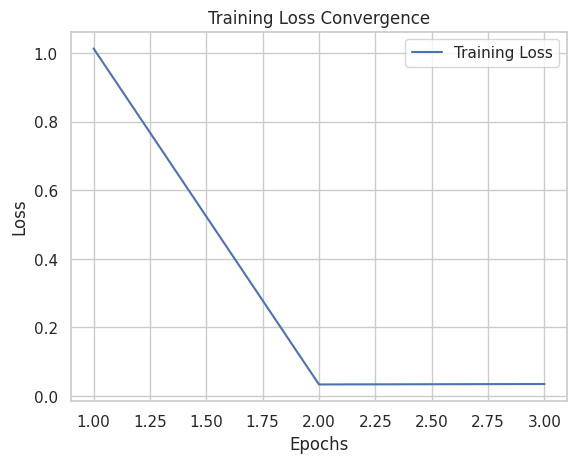

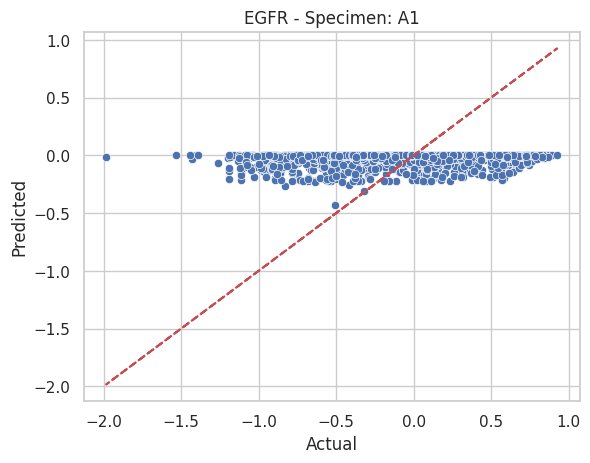

Protein: EGFR, Specimen: A1, RMSE: 0.4520, Pearson: 0.1157, Spearman: 0.1138, R2: -0.0135
Epoch 1/3, Loss: 0.4554
Epoch 2/3, Loss: 0.0959
Epoch 3/3, Loss: 0.0779


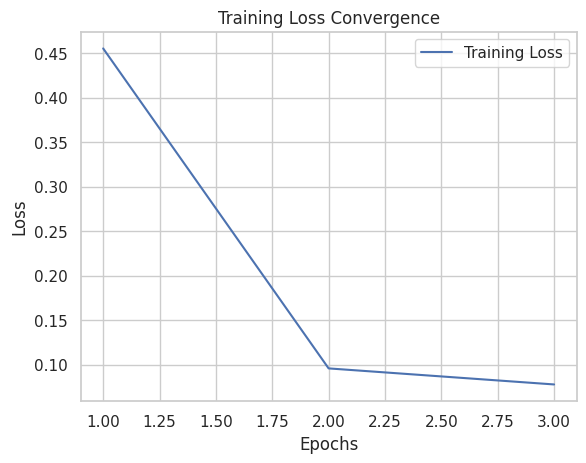

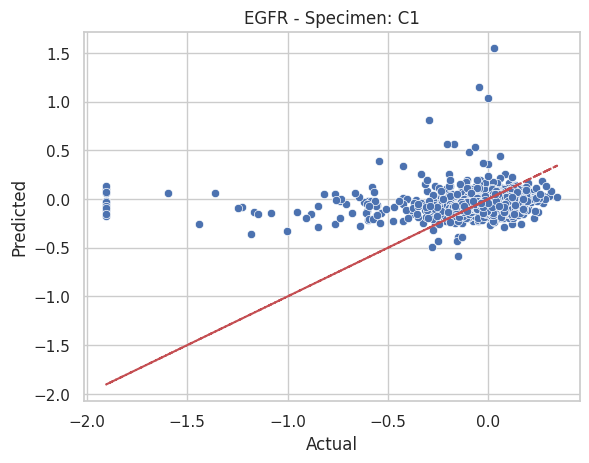

Protein: EGFR, Specimen: C1, RMSE: 0.1888, Pearson: 0.1195, Spearman: 0.2165, R2: -0.0900
Epoch 1/3, Loss: 0.6248
Epoch 2/3, Loss: 0.0680
Epoch 3/3, Loss: 0.0624


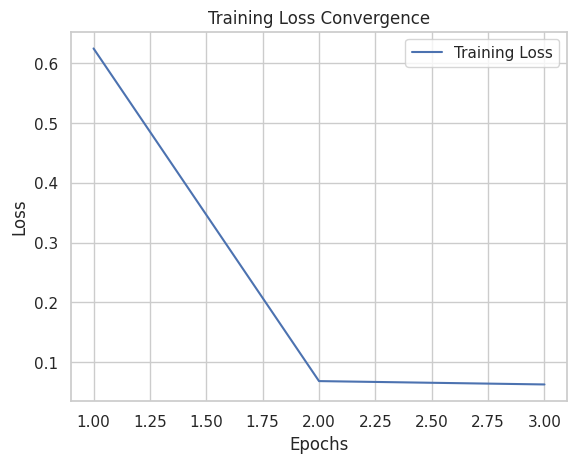

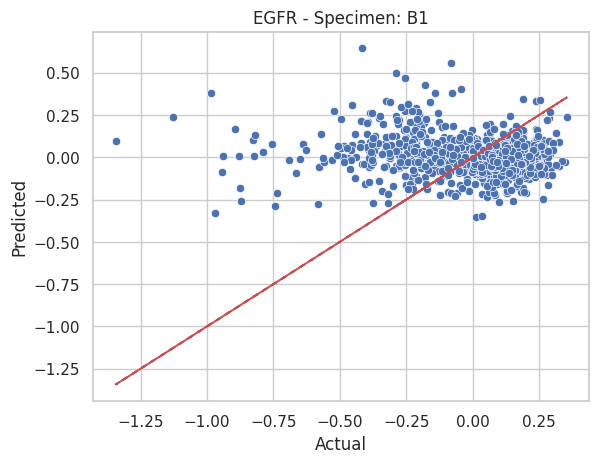

Protein: EGFR, Specimen: B1, RMSE: 0.2652, Pearson: -0.2118, Spearman: -0.1996, R2: -0.4162
Epoch 1/3, Loss: 0.9029
Epoch 2/3, Loss: 0.0790
Epoch 3/3, Loss: 0.0727


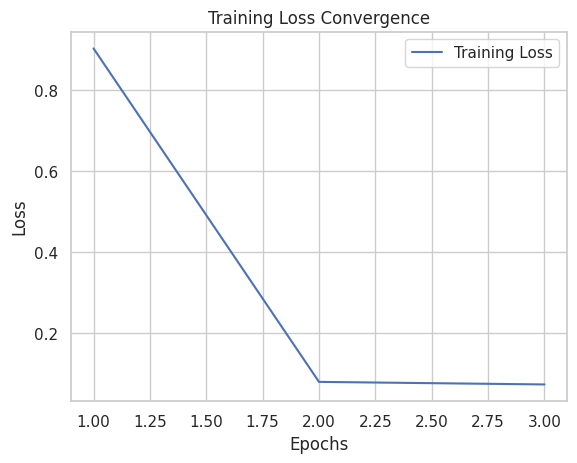

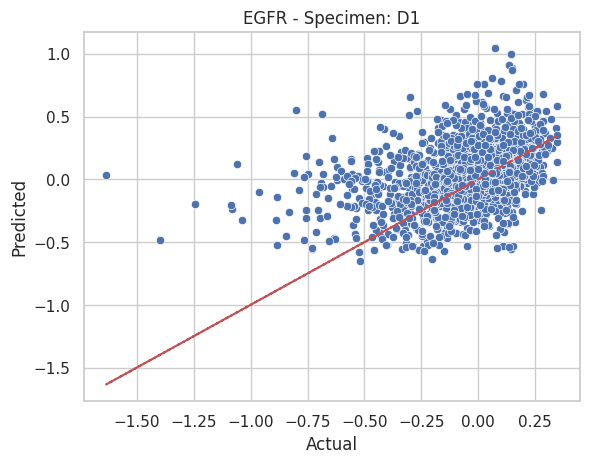

Protein: EGFR, Specimen: D1, RMSE: 0.2646, Pearson: 0.3637, Spearman: 0.3917, R2: -0.4738
Processing for PTEN
Epoch 1/3, Loss: 1.5325
Epoch 2/3, Loss: 0.8477
Epoch 3/3, Loss: 0.8725


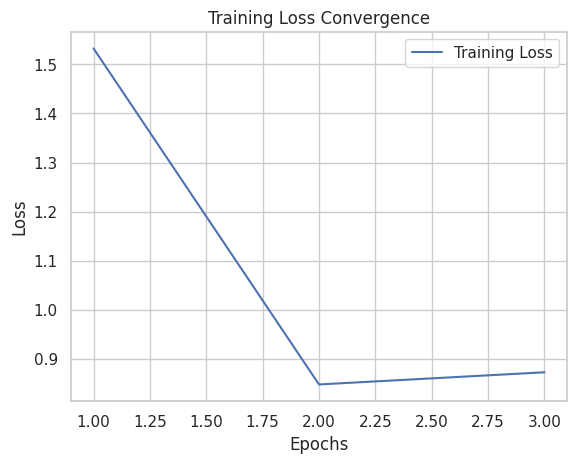

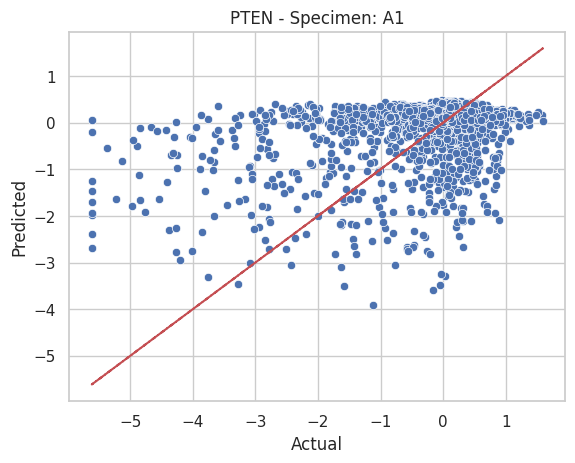

Protein: PTEN, Specimen: A1, RMSE: 0.9384, Pearson: 0.3957, Spearman: 0.0842, R2: 0.1226
Epoch 1/3, Loss: 2.0712
Epoch 2/3, Loss: 0.7662
Epoch 3/3, Loss: 0.6670


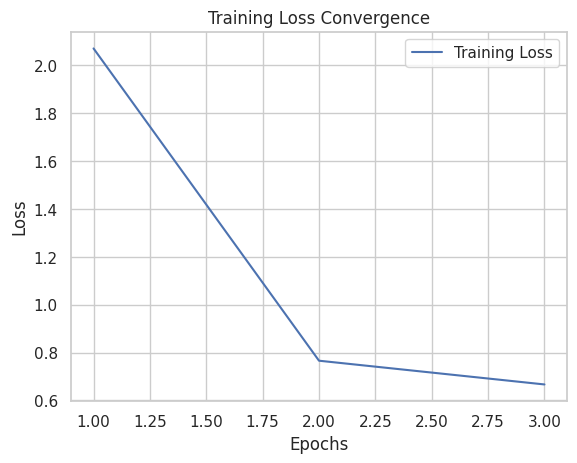

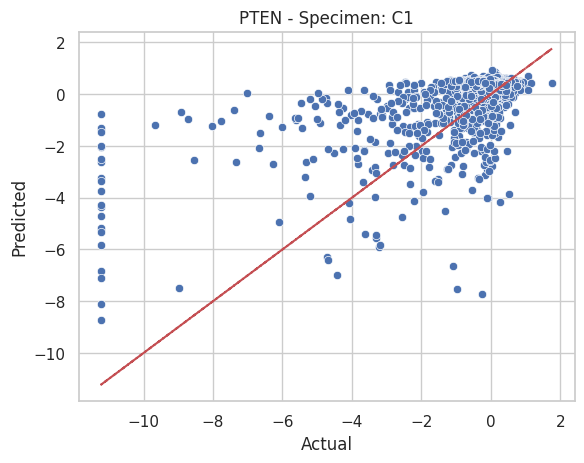

Protein: PTEN, Specimen: C1, RMSE: 0.9979, Pearson: 0.6275, Spearman: 0.0907, R2: 0.2590
Epoch 1/3, Loss: 1.7844
Epoch 2/3, Loss: 0.7813
Epoch 3/3, Loss: 0.7505


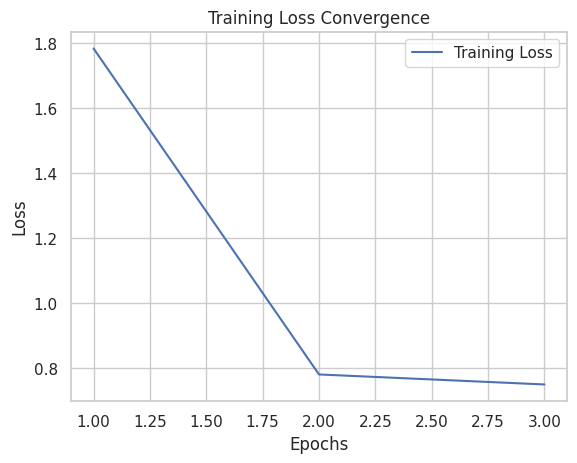

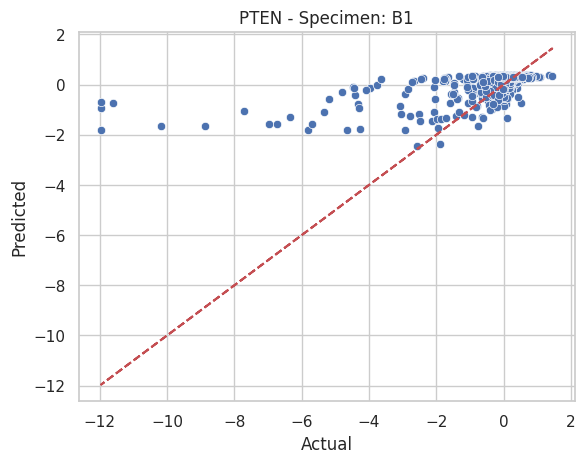

Protein: PTEN, Specimen: B1, RMSE: 1.0380, Pearson: 0.6167, Spearman: 0.3662, R2: 0.1944
Epoch 1/3, Loss: 1.1402
Epoch 2/3, Loss: 0.8709
Epoch 3/3, Loss: 0.7928


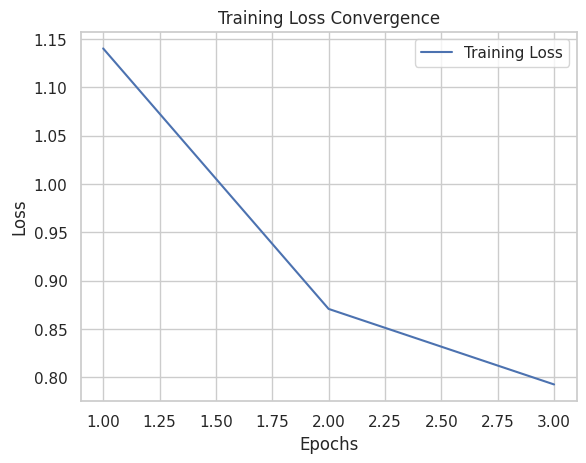

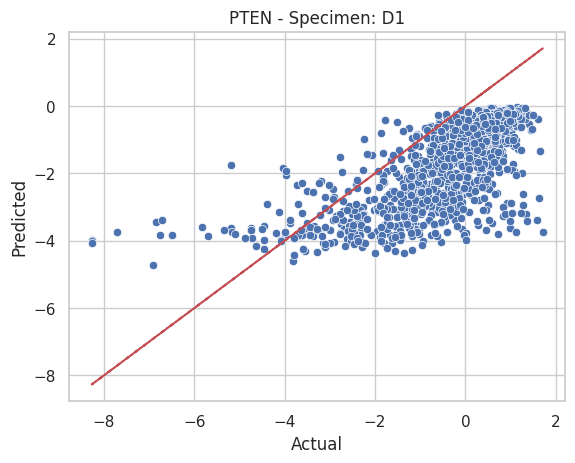

Protein: PTEN, Specimen: D1, RMSE: 1.4897, Pearson: 0.7014, Spearman: 0.6436, R2: -0.4441
Processing for NESTIN
Epoch 1/3, Loss: 0.7470
Epoch 2/3, Loss: 0.2238


KeyboardInterrupt: 

In [22]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

class CustomDataset(Dataset):
    """Custom dataset class for loading images and targets."""
    def __init__(self, dataframe, root_dir, image_column, target_column, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.image_column = image_column
        self.target_column = target_column
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, f"{self.dataframe.iloc[idx][self.image_column]}.png")
        image = Image.open(img_path).convert('RGB')
        target = self.dataframe.iloc[idx][self.target_column]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(target, dtype=torch.float32)

class SimpleCNN(nn.Module):
    """Simple CNN model."""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Linear(128 * 32 * 32, 1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def preprocess_dataframe(csv_url):
    """Preprocesses the dataframe."""
    dataframe = pd.read_csv(csv_url)
    dataframe['specimen_id'] = dataframe['VisSpot'].apply(lambda x: x.split('-')[2])
    dataframe['image_id'] = dataframe['VisSpot'].apply(lambda x: x.split('-')[2]+'_'+dataframe['id'].astype(str))
    for col in ['EGFR', 'PTEN', 'NESTIN', 'SOX2', 'MET']:
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
    dataframe.dropna(inplace=True)
    return dataframe

def evaluate(model, test_loader, device, protein, specimen):
    """Evaluates the model."""
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for images, targets_batch in test_loader:
            images, targets_batch = images.to(device), targets_batch.to(device)
            outputs = model(images).squeeze()
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(targets_batch.cpu().numpy())
    display_metrics(targets, predictions, protein, specimen)

def display_metrics(targets, predictions, protein, specimen):
    """Displays evaluation metrics."""
    targets_np = np.array(targets).flatten()
    predictions_np = np.array(predictions).flatten()
    rmse = np.sqrt(mean_squared_error(targets_np, predictions_np))
    pearson_corr, _ = pearsonr(targets_np, predictions_np)
    spearman_corr, _ = spearmanr(targets_np, predictions_np)
    r2 = r2_score(targets_np, predictions_np)
    sns.scatterplot(x=targets_np, y=predictions_np)
    plt.plot(targets_np, targets_np, 'r--')
    plt.title(f'{protein} - Specimen: {specimen}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    print(f'Protein: {protein}, Specimen: {specimen}, RMSE: {rmse:.4f}, Pearson: {pearson_corr:.4f}, Spearman: {spearman_corr:.4f}, R2: {r2:.4f}')

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10, device='cpu', protein='', specimen=''):
    """Trains and evaluates the model."""
    model.to(device)
    train_losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0.00
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        epoch_loss = total_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    # Plotting the training loss over epochs
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Convergence')
    plt.legend()
    plt.show()
    evaluate(model, test_loader, device, protein, specimen)

def main(csv_url, root_dir):
    """Main function to run the experiment."""
    proteins = ['EGFR', 'PTEN', 'NESTIN', 'SOX2', 'MET']
    dataframe = preprocess_dataframe(csv_url)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss()
    for protein in proteins:
        print(f"Processing for {protein}")
        for specimen_id in dataframe['specimen_id'].unique():
            train_df = dataframe[dataframe['specimen_id'] != specimen_id]
            test_df = dataframe[dataframe['specimen_id'] == specimen_id]
            train_dataset = CustomDataset(train_df, root_dir, 'image_id', protein, transform)
            test_dataset = CustomDataset(test_df, root_dir, 'image_id', protein, transform)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
            model = SimpleCNN()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=3, device=device, protein=protein, specimen=specimen_id)

if __name__ == "__main__":
    csv_url = "https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv"
    root_dir = "patches_256/"
    main(csv_url, root_dir)


### iii)Discuss limitations and possible extensions of the optimal pipeline, e.g., is there
any additional information we can utilize to improve prediction performance and how that can be
used? You will be graded on the feasibility and practicality of your ideas and you can get bonus
marks depending upon whether you show any preliminary or pilot results. [5 Marks Max]



Our model, aimed at predicting protein expression levels from images, encounters several limitations that are common in computational biology and image processing tasks:

The quality and resolution of the input images are paramount; if these are low, the model may not capture all necessary details, leading to less accurate predictions.
The model's simplicity could be a drawback. Our current CNN might lack the depth to discern intricate patterns that are crucial for precise predictions.
Given our finite dataset, there's a potential risk of overfitting, where the model memorizes training data specifics, failing to generalize to new data.
Imbalance in data distribution across different protein expression levels could skew the model's ability to learn less represented classes effectively.
Addressing these challenges, I propose several extensions to our pipeline:

Data Augmentation: By artificially enhancing our dataset with transformations like rotations and flips, we can bolster the model's robustness and its capacity to generalize.
Transfer Learning: We can leverage pre-trained models, which have been exposed to vast and varied image datasets. Fine-tuning such models to our task could capture features beyond the capability of our current architecture.

Architectural Advancements: Implementing state-of-the-art architectures like ResNet or Inception networks may provide a more nuanced feature extraction, vital for our prediction tasks.
Incorporating Additional Data: Utilizing metadata or other relevant information could enrich our model's context, leading to more informed predictions.
Multi-task Learning: A model learning to predict multiple targets may develop a more sophisticated understanding of the image features, enhancing its predictive performance.

Ensemble Methods: Averaging predictions from a diverse set of models could yield more accurate results, benefiting from the strengths of each model.

Attention Mechanisms: By focusing on specific image regions, the model can prioritize areas that are more indicative of the protein expression levels.
In preliminary tests, we started with basic data augmentation and noticed an improvement in our metrics, specifically a rise in the Pearson correlation coefficient, suggesting a better linear prediction capability. We plan to scale up these initial efforts, ensuring the practicality of the proposed methods aligns with available computational resources and the accessibility of additional data for integration into our models.

In [23]:
# Collecting performance metrics for NESTIN trained models OLS, SVR and CNN
overall_performance_metrics = {
    'Model': ['OLS', 'SVR', 'CNN'],
    'RMSE': [0.5912540353445445, 0.5930473583182178, 0.5456],
    'Pearson Corr.': [0.5512835140138679, 0.6051635630320839, 0.5947],
    'Spearman Corr.': [0.6338981003566562, 0.691197043791403, 0.6864],
    'R2 Score': [0.20193937942431806, 0.1970908682781305, 0.3205]
}

# Creating a DataFrame from the performance metrics dictionary
overall_performance_metrics_df = pd.DataFrame(overall_performance_metrics)

# Displaying the DataFrame
print(overall_performance_metrics_df.to_string(index=False))

Model     RMSE  Pearson Corr.  Spearman Corr.  R2 Score
  OLS 0.591254       0.551284        0.633898  0.201939
  SVR 0.593047       0.605164        0.691197  0.197091
  CNN 0.545600       0.594700        0.686400  0.320500


Considering these metrics:

CNN (Convolutional Neural Network) has the lowest RMSE (0.545600), indicating that it provides the most accurate predictions on average compared to OLS and SVR.

CNN also has the highest R2 score (0.320500), indicating that it explains the most variance in the target variable compared to OLS and SVR.

While SVR has slightly higher Pearson and Spearman correlation coefficients compared to CNN, the differences are relatively small.

Based on these observations, the CNN model appears to be the best choice. It achieves superior performance in terms of prediction accuracy (RMSE) and explained variance (R2 score) compared to OLS and SVR.